In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import os 

import numpy as np

import pandas as pd

from umap import UMAP

from tensorflow.keras.models import load_model

from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, Birch
from hdbscan import HDBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

from modules.utils.viz_utils import cluster_inspection

In [3]:
sns.set(font_scale=1.5, style='whitegrid')

## Load objects

In [22]:
extractor = load_model('results\\models\\features_extractor')
estimator = load_model('results\\models\\sentiment_estimator')
decoder = pd.read_pickle('results\\objects\\decoder.pkl')
sentiments_mapper = {
    0: 'Neutral',
    1: 'Positive',
    2: 'Negative'
}

In [5]:
embeddings = []
sentences = []
padded_sentences = []
sentiments = []
for batch in range(len(os.listdir('data\\inputs'))):
    
    inp_btch = np.load(f'data\\inputs\\{batch}.npy')
    
    embeddings.append(extractor.predict(inp_btch)[:, -1, :])
    sentences.append(inp_btch)
    sentiments.append(estimator.predict(inp_btch)[0].argmax(axis=2)[:, -1])

for btch in sentences:
    
    padded = np.zeros(shape=(btch.shape[0], 120))
    padded[:, 0: btch.shape[1]] = btch
    padded_sentences.append(padded)
    
sentences = np.vstack(padded_sentences)
embeddings = np.vstack(embeddings)
sentiments = np.hstack(sentiments)

In [8]:
manifolds = UMAP(n_components=2, n_neighbors=100, verbose=True, n_epochs=500).fit_transform(embeddings)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=500,
     n_neighbors=100, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Aug 25 17:39:03 2020 Finding Nearest Neighbors
Tue Aug 25 17:39:03 2020 Building RP forest with 11 trees
Tue Aug 25 17:39:03 2020 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
Tue Aug 25 17:39:15 2020 Finished Nearest Neighbor Search
Tue Aug 25 17:39:16 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  

## Simple Predictions

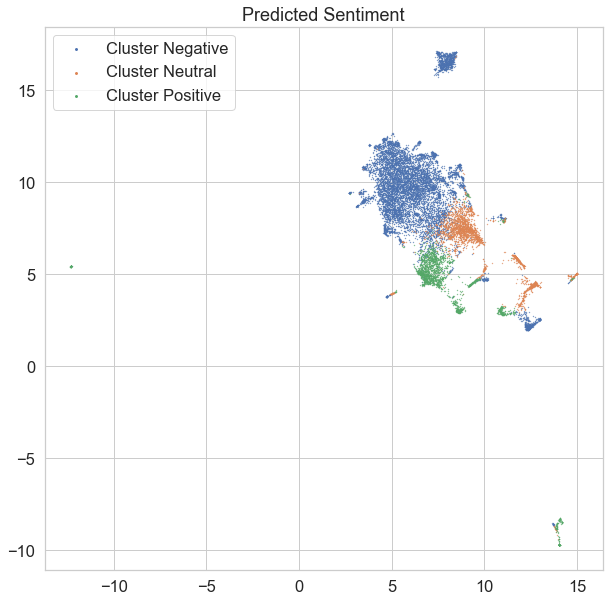


Cluster Negative

Negative : 1.0

* i was just very surprised it took over mins never experienced anything like that on number

* and no offers to provide us with a hotel or anything for a flight that is over hours away

* unbelievable that i can not even wait on hold to speak to a human being to resolve my issue the system simply hangs up

* cost me day of vacation and all i got was a rude woman tell me to go to another country and figure out how to get

* waited in the airport for two days to get home not weather relate flightd dealt with horrible customer service finally switched to

* i flying ua but with

* mobile boarding pass disappeared from phone while standing in line to board second time this week hmm

* did bags make it on the flight out of iad second day without clothes is pretty inconvenient we pretty curious unitedairlines

* waiting for you to figure it out this is unacceptable

* my flight cancelled flighted tonight u auto rebooked flight on tuesday that does work can

In [24]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    np.vectorize(sentiments_mapper.get)(sentiments), 
    title='Predicted Sentiment',
    embedding=embeddings,
    decoder=decoder,
    pad=0,
    s=0.1
)

## Clustering With K-means

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


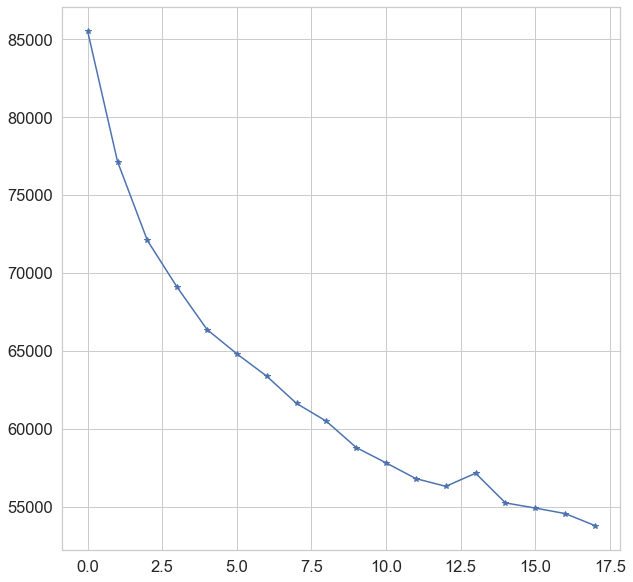

In [10]:
inertias=[]
for k in range(2, 20):
    
    print(k)
    clusterer= MiniBatchKMeans(k, n_init=100)
    clusterer.fit(embeddings)
    inertias.append(clusterer.inertia_)
    
plt.figure(figsize=(10, 10))
plt.plot(inertias, marker='*')
plt.show()

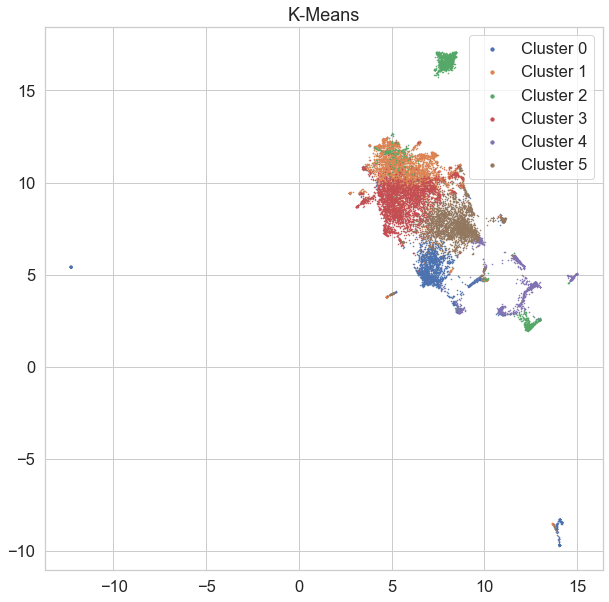


Cluster 0

Negative : 0.106
Neutral : 0.02
Positive : 0.873

* ooh thanks

* was able to send the dm all good now

* thanks heartlanta

* glad it was finally resolved too too bad i ca get a free voucher to go with mine so i can have a friend travel next time

* had a great flight to orlando from hartford a few weeks ago was great to get out on time and arrive early

* no apology cool

* omg nonstop dallas to austin on

* thanks to karen salisbury at iah for amazing customer service found my daughter bag lost on made her day

* thank you for leaving my bag in houston despite what your system says i was definitely on the flight

* we made it to seattle


Cluster 1

Negative : 1.0

* i would be on my way but wether has delayed yet love the charlotte ice storm good luck with mad customers

* second she sat on the tarmac for hrs only to be told it would be mins

* she missed her uncle funeral and you hope they can find another flight that very considerate of you

* trying to rebook a fligh

In [12]:
clusterer= MiniBatchKMeans(6, n_init=100)
clusterer.fit(embeddings)
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='K-Means',
    embedding=embeddings,
    decoder=decoder,
    pad=0,
    s=0.3
)

## Clustering with HDBSCAN

In [13]:
clusterer = HDBSCAN(min_cluster_size=100, min_samples=40)
clusterer.fit(embeddings)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=100, min_samples=40, p=None,
        prediction_data=False)

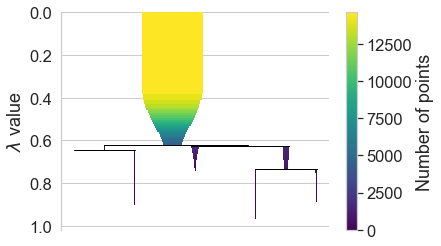

In [14]:
clusterer.condensed_tree_.plot()
plt.show()

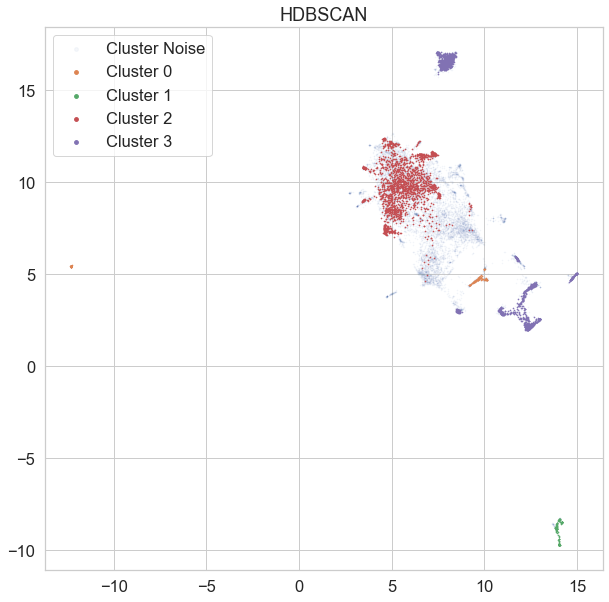


Cluster -1

Negative : 0.644
Neutral : 0.201
Positive : 0.155

* my bags are on the way to chicago without me help i was confirmed for flights and told there is room and i screwed

* hrs bags being returned to us after flight cancelled flightled maybe put a couple people on it

* yes i am rno departure at on at dfw to lga i can do the to lax and then to jfk

* flight jfk to tpa on saturday one way ticket

* is this a joke my return flight is delayed too in a row new record from you guys

* yay for glitchy tracking system my bags made it to my destination and not laguardia like the app said

* jetblue our fleet on fleek http lol wut

* lt lt lt lt lt lt do not reply to emails

* ca fly in precipitation and has planes that do work after airline had better be a charm tomorrow

* why when you book a flight now does jetblue separate a old from the mother is that a bit stupid headaches


Cluster 0

Negative : 0.193
Neutral : 0.089
Positive : 0.719

* the bright side would be keeping the pro

In [15]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='HDBSCAN',
    embedding=embeddings,
    decoder=decoder,
    pad=0,
    s=0.4
)

## Clustering with Affinity Propagation

In [16]:
clusterer = Birch()
clusterer.fit(embeddings)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
      threshold=0.5)

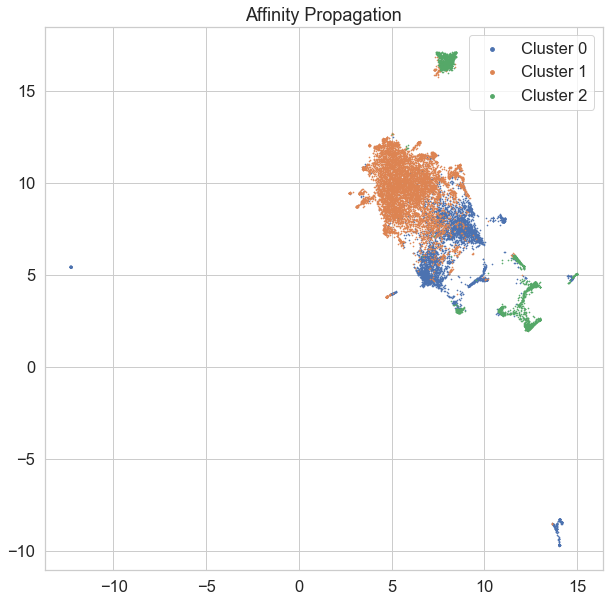


Cluster 0

Negative : 0.224
Neutral : 0.387
Positive : 0.388

* thank you for not even coming with a solution great service i might say as a trueblue member i am totally dissatisfied thanks

* so that what happens when your power level goes over feet in the air

* will do appreciate the replies though

* what going on with passengers diverted to clt on fll to phl flight that left at tonight

* sign me up

* dont have atlanta to san fransisco in in the present sale like u had in the last sale im looking for return tickets

* thank you for asking

* my hubby has a layover in dfw fm the cxl flt pls help get him home sooner if you can any room on bwi or phl today

* absolutely

* could you check if there is svu space on feb thanks


Cluster 1

Negative : 0.963
Neutral : 0.025
Positive : 0.012

* we been on hold for over hours after my wife flight was cancelled flighted

* bags are still in houston since friday and still have not been reimbursed the baggage fee

* a late flight plane then 

In [17]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='Affinity Propagation',
    embedding=embeddings,
    decoder=decoder,
    pad=0,
    s=0.4
)

## Clustering Agglomerative

In [18]:
clusterer = AgglomerativeClustering(7)
clusterer.fit(embeddings)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=7)

In [19]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='Agglomerative Clustering',
    embedding=embeddings,
    decoder=decoder
    pad=0,
    s=0.4
)

SyntaxError: invalid syntax (<ipython-input-19-59ebcdb1ff07>, line 9)